In [47]:
import numpy as np
import matplotlib.pyplot as plt
from es import CMAES
import FlightSimTVC
import FlightSimAero
import FlightSimAtt
from scipy.spatial.transform import Rotation as R

In [48]:
# Constants
drop_height = 20                    # meters
fin_area = 0.0065366                # area of one fin [m^2]
lever_f = np.array([0,0,0.26])      # vector from cg of fin to cp (meters) 11/10/22
lever_c = np.array([0,0,0.08671])   # vector from cg of body/legs/cap to cp (meters) KEEP SAME

In [49]:
# Define main simulation function
def simulate(t_ignite,Kp,Kd,drop_height,fin_area,lever_c,lever_f,wind,omega_init):

    dt = 0.01                       # time step
    t_sim = np.arange(0,4,dt)       # time range for simulation
    loops = len(t_sim)              # number of steps

    # arrays for collecting data
    acc = np.zeros((loops,3))                   # acceleration vector of rocket
    v = np.zeros((loops,3))                     # velocity vector of rocket      
    p = np.zeros((loops,3))                     # position vector of rocket
    q = np.zeros((loops,4))                     # quaternion of rocket attitude
    omega = np.zeros((loops,3))                 # angular velocity of rocket
    aero_torque = np.zeros((loops,3))
    aero_force = np.zeros((loops,3))
    thrust_force = np.zeros((loops,3))          # body frame
    thrust_torque = np.zeros((loops,3))         # body frame
    torque = np.zeros((loops,3))
    z_i = np.zeros((loops,3))                   # unit vector of z axis of rocket in fixed frame
    z_angle = np.zeros(loops)                   # rocket angle from vertical

    # Initial Conditions
    m = 0.95                                                # rocket initial mass (kg)
    g = np.array([ 0, 0,-9.81])                             # gravitational acceleration (m/s^2), Z axis is up
    acc[0,:] = g                                            # acceleration (m/s^2)
    v[0,:] = np.array([0.00001,0.0000001,0.000001])         # velocity (m/s)
    p[0,:] = np.array([0,0,drop_height])                    # position (m)
    omega[0,:] = omega_init                                 # angular rate (rad/sec)
    torque[0,:] = np.zeros(3)                               # (N-m)
    

    z_i[0,:] = np.zeros(3)

    r = R.from_euler('ZYX',np.array([0, 0, 0]))
    q0 = r.as_quat().T
    q[0,:] = q0    

    # Rocket model parameters
    feet_area_v = (np.pi*0.025**2) * 4
    legs_area_v = (0.03*0.14) *4
    tube_circle = np.pi*0.04**2
    base_area = feet_area_v+legs_area_v+tube_circle         # vertically projected area of rocket
    legs_area_s = (0.01*0.160+0.05*0.06) *2
    tube_diameter = 0.07874
    length = 0.3302
    tube_diameter = 0.07874
    tube_side_area = length * tube_diameter
    side_area = tube_side_area + 2*fin_area  + legs_area_s  # horizontally projected area of rocket


    cd_base = 1.15                                          # drag coeff of rocket in pure vertical descent (experimentally determined)
    cd_side = 1.28                                          # drag coeff of rocket in pure horizantal descent with 2 fins perpendicular to flow (approximated)

    # Engine parameters for mass calculation
    net_impulse = 13.8                      # net impulse from ThrustCurve.com (Ns)
    m_propellant = 0.009                    # propellant of mass from ThrustCurve.com (kg)
    Isp = net_impulse/(m_propellant*9.81)   # specific impulse (s)

    # initialize servo servo angles
    phi_save = np.zeros(loops)
    theta_save = np.zeros(loops)

    # create attitude_simulator object 
    att_sim_obj = FlightSimAtt.attitude_simulator( q[0,:], omega[0,:], dt )

    # create aero_simulator object
    aero_sim_obj = FlightSimAero.aero_simulator( lever_f, lever_c, fin_area, side_area)

    # create tvc_simulator object
    tvc_sim_obj = FlightSimTVC.tvc_simulator(dt,Kp,Kd)
    burn_time = tvc_sim_obj.t_thrust[-1]


    # loop through time step and simulate dynamics
    i = 0     # index i tracks simulation time step
    j = 0     # index j tracks time step within thrust curve
    while i < loops-1:

        #------- run attitude simulator --------%
        # this updates the rocket orientation for the next time step
        att_sim_obj.att_RK4( torque[i,:] )
        omega[i+1,:] = att_sim_obj.w
        q[i+1,:] = att_sim_obj.q
        rot = R.as_matrix(R.from_quat([q[i+1,1],q[i+1,2],q[i+1,3],q[i+1,0]]))
    
        #-------- run aero simulator --------%
        aero_torque[i,:], aero_force[i,:], z_i[i,:], z_angle[i] = aero_sim_obj.aero_3d( rot, v[i,:], omega[i,:], q[i,:],cd_base, cd_side, base_area, side_area, wind )

        #-------- free fall condition --------%
        # note: used both before and after burn
        if t_sim[i] < t_ignite or t_sim[i] >= t_ignite + burn_time:
            # no thrust so...
            thrust_force[i,:] = np.zeros(3)
            thrust_torque[i,:] = np.zeros(3)
            phi_save[i] = 0
            theta_save[i] = 0     # Define as zero after engine stops thrusting

            # translation motion
            # update rocket position for next time step based on current position and applicable forces
            acc[i+1,:] = g + aero_force[i,:] / m
            p[i+1,:] = p[i,:] + v[i,:] * dt + 0.5 * acc[i+1,:] * dt**2
            v[i+1,:] = v[i,:] + acc[i+1,:] * dt

        #-------- power descent --------%
        else:
            # print(f"time: {t_sim[i]})")
            # Control in general is calculated about every 0.04 seconds
            if j == 0 or j%4 == 0:
                thrust_torque[i,:], thrust_force[i,:], phi_save[i], theta_save[i] = tvc_sim_obj.tvc_control( q[i-3,:], omega[i- 3,:], j, phi_save[i-1],theta_save[i-1] )
        
            # between these larger control steps, the control output is maintained at the most recent values returned by tvc_control
            else:                   
                thrust_force[i,:] = thrust_force[i-1,:]
                thrust_torque[i,:] = thrust_torque[i-1,:]
                theta_save[i] = theta_save[i-1]
                phi_save[i] = phi_save[i-1]

            # translation motion
            # update rocket position for next time step based on current position and applicable forces
            acc[i+1,:] = g + rot @ thrust_force[i,:]/m + aero_force[i,:] / m    # rotate thrust force into inertial frame
            p[i+1,:] = p[i,:] + v[i,:] * dt + 0.5 * acc[i,:] * dt**2
            v[i+1,:] = v[i,:] + acc[i+1,:] * dt
            # update mass
            mdot = -tvc_sim_obj.thrust_curve[j]/(9.81*Isp)
            m = m + mdot * dt
            # update thrust time step
            j += 1
    

        # update total torque acting on rocket 
        torque[i+1,:] = thrust_torque[i,:] + aero_torque[i,:]

        # update simulation time step
        i += 1

        #-------- landed --------%
        if  p[i,2] <= 0.:
            #trim remaining zeros...
            p = p[:i,:]
            v = v[:i,:]
            acc = acc[:i,:]
            z_i = z_i[:i,:]
            z_angle = z_angle[:i]
            q = q[:i,:]
            phi_save = phi_save[:i]
            theta_save = theta_save[:i]
            #...and exit the while loop
            break 

    return (p,v,z_angle,phi_save,theta_save,t_sim)

In [50]:
def cost(params, max_wind=1.4, max_angvel=3, num_sims=50):

    (t_ignite, Kp, Kd) = params

    net_v = 0
    net_ang = 0

    rand3s = np.random.multivariate_normal([0, 0, 0], np.diag([0.5, 0.5, 0.1]), num_sims+1)
    for i in range(num_sims):
        wind = rand3s[i]
        omega_init = rand3s[i+1]*0.1
        # print(wind, omega_init)

        
        (p,v,z_angle,phi_save,theta_save,t_sim) = simulate(t_ignite, Kp, Kd, drop_height, fin_area, lever_c, lever_f,wind,omega_init)
        net_v += v[-1,2]
        net_ang += -z_angle[-1] * 10

        # print(net_v/(i+1), net_ang/(i+1))
    avg_v = net_v/num_sims
    avg_ang = net_ang/num_sims
    # print(f"avg v: {avg_v}")
    # print(f"avg ang: {avg_ang}")
    net_cost = avg_v + avg_ang
    return net_cost

fit_func = cost
    
guess = (1.2, 0.04, 0.0)
print("F of guess:")
print(fit_func(guess))

F of guess:
-7.45194829975405


In [51]:
NPARAMS = 3        # make this a 100-dimensinal problem.
NPOPULATION = 20    # use population size of 101.
MAX_ITERATION = 10 # run each solver for 5000 generations.

In [52]:
# defines a function to use solver to solve fit_func
def test_solver(solver):
  history = []
  for j in range(MAX_ITERATION):
    solutions = solver.ask()
    # if j == 0:
    #   solutions = np.full((NPOPULATION, NPARAMS), guess)

    # print(solutions)

    fitness_list = np.zeros(solver.popsize)
    for i in range(solver.popsize):
      fitness_list[i] = fit_func(solutions[i])

    solver.tell(fitness_list)
    result = solver.result() # first element is the best solution, second element is the best fitness
    history.append(result[1])
    if (j+1) % 1 == 0:
      print("fitness at iteration", (j+1), result[1], result[0], solver.rms_stdev())
  print("local optimum discovered by solver:\n", result[0])
  print("fitness score at this local optimum:", result[1])
  return history

# defines CMA-ES algorithm solver
cmaes = CMAES(NPARAMS,
  x0=guess,
  popsize=NPOPULATION,
  weight_decay=0.0,
  sigma_init = 0.01
)

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 3 (seed=429602, Sat Nov 12 08:37:12 2022)


In [53]:
cma_history = test_solver(cmaes)

fitness at iteration 1 -7.167192474538059 [1.17952763 0.04208635 0.00204704] 0.012841424110789057
fitness at iteration 2 -7.167192474538059 [1.17952763 0.04208635 0.00204704] 0.013599632121031368
fitness at iteration 3 -7.1554884449168465 [ 1.17822254  0.02868462 -0.00362811] 0.014441181768090788
fitness at iteration 4 -7.1554884449168465 [ 1.17822254  0.02868462 -0.00362811] 0.01572890750464775
fitness at iteration 5 -7.147463073392588 [1.17559755 0.04238408 0.00320697] 0.012626198248030901
fitness at iteration 6 -7.147463073392588 [1.17559755 0.04238408 0.00320697] 0.011319886202095265
fitness at iteration 7 -7.147463073392588 [1.17559755 0.04238408 0.00320697] 0.009605601935881511
fitness at iteration 8 -7.134846733411101 [ 1.17920562  0.04461052 -0.00425103] 0.008871847373357864
fitness at iteration 9 -7.134846733411101 [ 1.17920562  0.04461052 -0.00425103] 0.007592981583088922
fitness at iteration 10 -7.134846733411101 [ 1.17920562  0.04461052 -0.00425103] 0.009392344781881817
loc

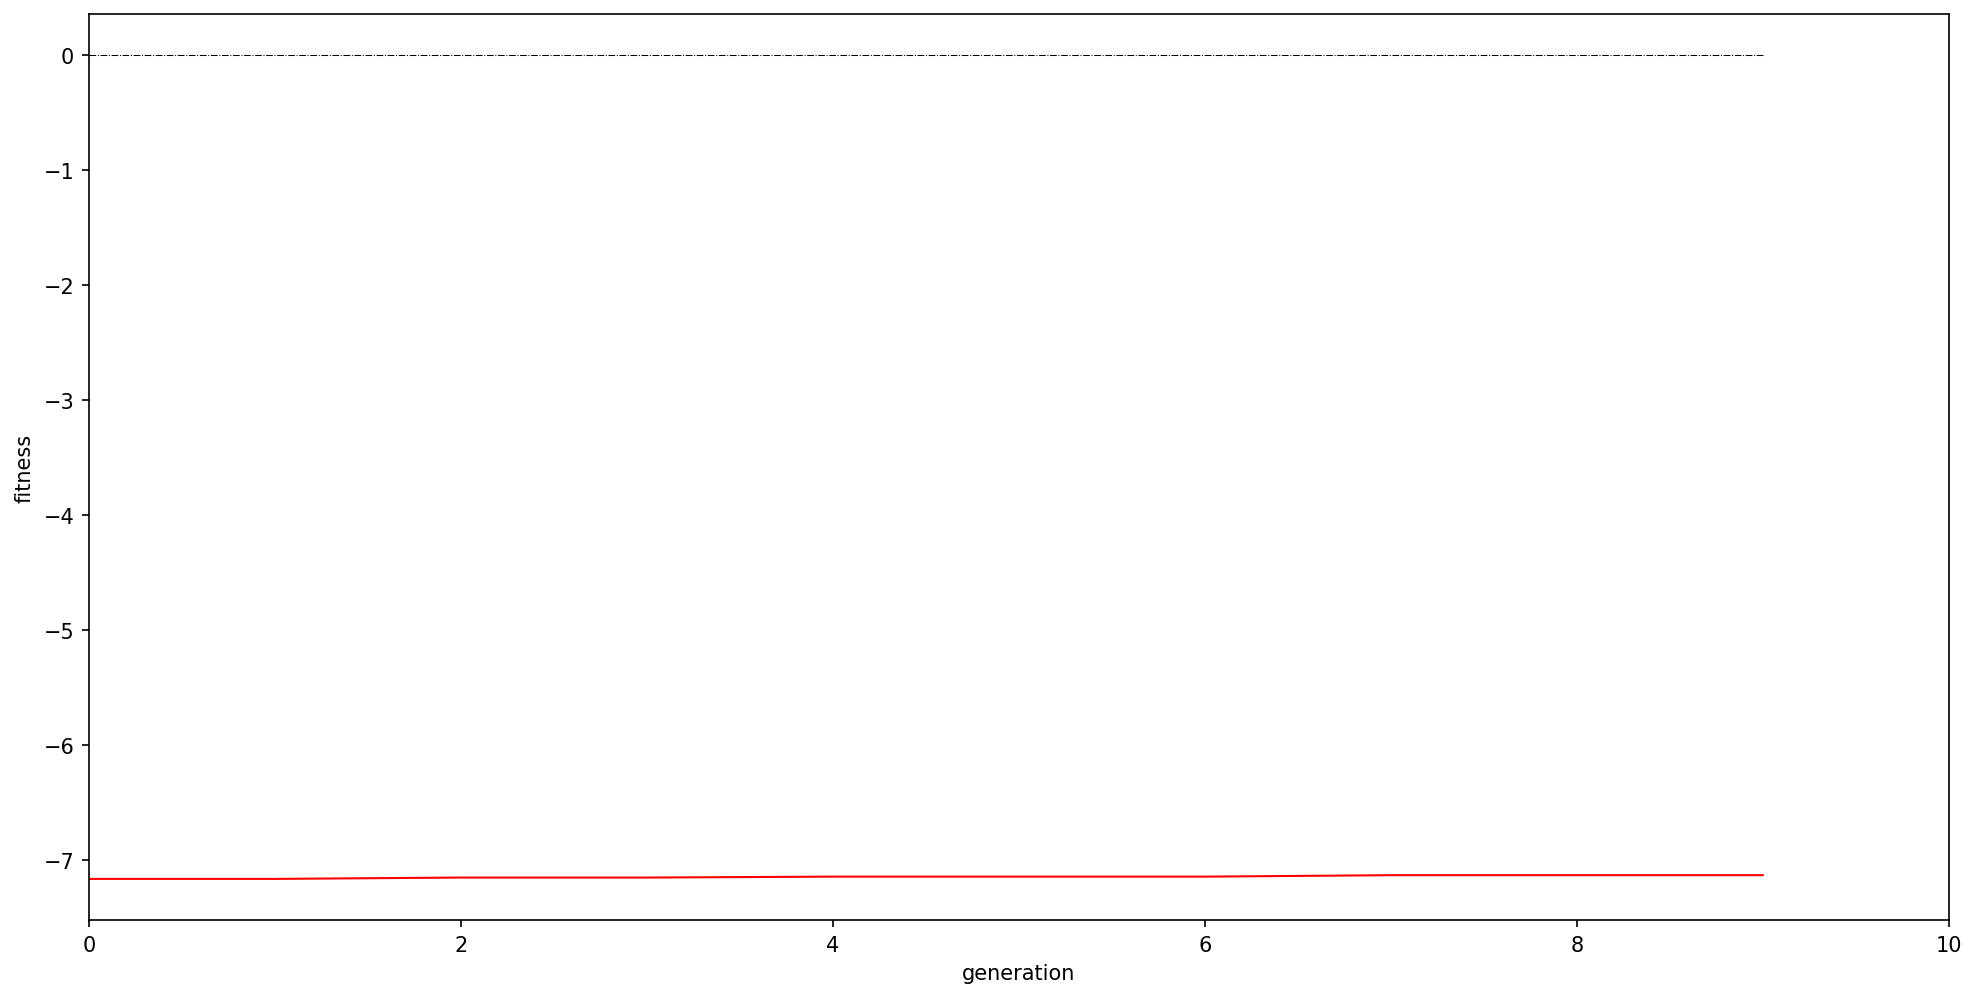

In [54]:
# Create a new figure of size 8x6 points, using 100 dots per inch
best_history = [0] * MAX_ITERATION
plt.figure(figsize=(16,8), dpi=150)

optimum_line, = plt.plot(best_history, color="black", linewidth=0.5, linestyle="-.", label='Global Optimum')
cma_line, = plt.plot(cma_history, color="red", linewidth=1.0, linestyle="-", label='CMA-ES')

# Set x limits
plt.xlim(0,MAX_ITERATION)

plt.xlabel('generation')
plt.ylabel('fitness')

# plt.savefig("./rastrigin_10d.svg")

plt.show()